In [2]:
import pandas as pd
import astropy.io.fits as pyfits
import glob
import numpy as np
import matplotlib.pyplot as plt
import photutils.isophote as isophot

In [3]:
import os
os.chdir('/nas/t7black/astro465_data/wiyn09m/170603')
!pwd

/nas/t7black/astro465_data/wiyn09m/170603


In [4]:
rband = pyfits.open("abell2197_r.fits")[0].data
vband = pyfits.open("abell2197_v.fits")[0].data

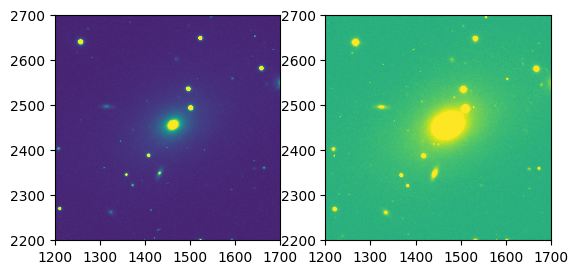

In [5]:
fig,axs = plt.subplots(ncols=2)
axs[0].imshow(vband[2200:2700, 1200:1700], extent=[1200,1700,2200,2700], origin='lower', vmin=1500,vmax=3800)
axs[1].imshow(rband[2200:2700, 1200:1700], extent=[1200,1700,2200,2700], origin='lower', vmin=1500,vmax=3800)

In [6]:
# set some starting values for position and size. Shapes and sizes will be refined during fitting, but
# at least x0/y0 should be close enough to identify the right object
geometry = isophot.EllipseGeometry(x0=1472, y0=2453, sma=20, eps=0.5, pa=np.radians(20))

In [7]:
ellipse_r = isophot.Ellipse(rband, geometry)
iso_r = ellipse_r.fit_image()

In [8]:
print(iso_r)

In [9]:
def make_plots(iso, geometry):

    fig, axs =  plt.subplots(ncols=2, nrows=2, figsize=(7,7))

    axs[0,0].scatter(iso.sma, iso.intens-np.min(iso.intens), s=1)
    axs[0,0].set_yscale('log')
    #axs[0,0].set_xscale('log')
    axs[0,0].set_title("intensity")

    axs[0,1].scatter(iso.sma, iso.eps, s=1)
    axs[0,1].set_title("ellipticity")

    axs[1,0].scatter(iso.sma, iso.pa, s=1)
    axs[1,0].set_title("position angle")

    axs[1,1].scatter(iso.sma, iso.x0-geometry.x0, s=1, label='x')
    axs[1,1].scatter(iso.sma, iso.y0-geometry.y0, s=1, label='y')
    axs[1,1].legend()
    axs[1,1].set_title("position angle")

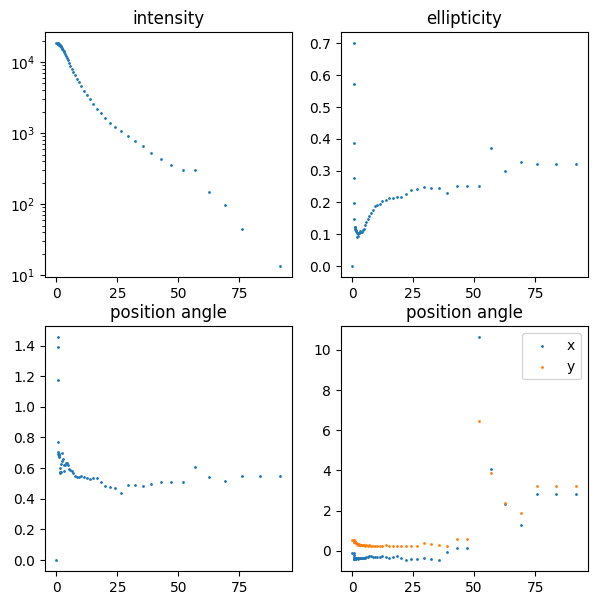

In [10]:
make_plots(iso_r, geometry)

In [11]:
geometry_v = isophot.EllipseGeometry(x0=1462, y0=2454, sma=30, eps=0.2, pa=np.radians(20))
ellipse_v = isophot.Ellipse(vband, geometry_v)
iso_v = ellipse_v.fit_image()
print(iso_v)

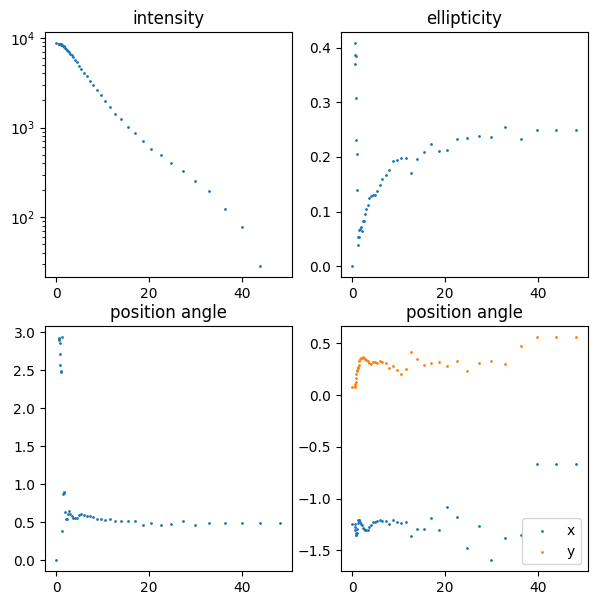

In [12]:
make_plots(iso_v, geometry_v)

In [13]:
isolist_narrow_ = []
for iso in iso_r[1:]:

    # Get the EllipseGeometry of each fitted isophote as determined by 
    # fitting on the high-S/N inage.
    g = iso.sample.geometry
    # print(g.x0, g.y0)
    g.x0 = g.x0 - geometry.x0 + geometry_v.x0
    g.y0 = g.y0 - geometry.y0 + geometry_v.y0 
    # print(g.x0,g.y0)
    # print()
    
    # Sample the low-S/N image at the same geometry. Use the same integration 
    # mode so as to ensure the same regions in each image are sampled. 
    # Use the same clipping parameters as used in the high-S/N image.
    sample = isophot.EllipseSample(vband, g.sma, geometry=g, 
                           integrmode='median', sclip=3.0, nclip=3)
    sample.update()

    # Create an Isophote instance with the sample, and store it in 
    # temporary list. Here we are using '0' as the number of iterations,
    # 'True' for the validity status, and '0' for the stop code. These
    # are in fact arbitrary in this context; you could use anything you
    # like.
    iso_ = isophot.Isophote(sample, 0, True, 0)
    isolist_narrow_.append(iso_)

# Build the IsophoteList instance with the result.
iso_v_matched = isophot.IsophoteList(isolist_narrow_)

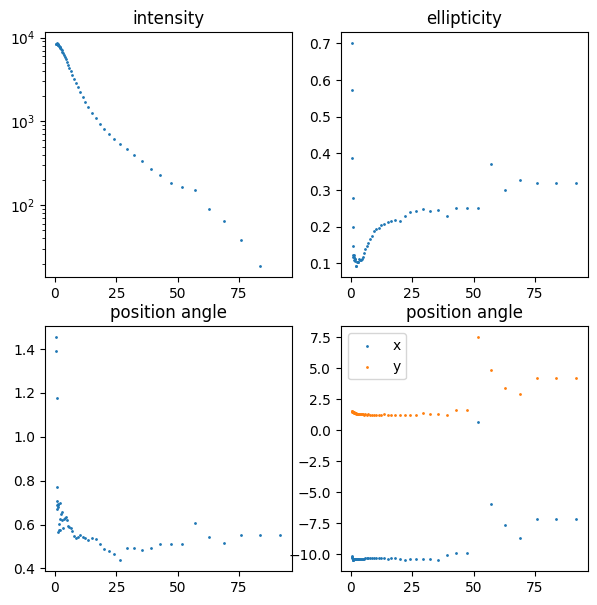

In [14]:
make_plots(iso_v_matched, geometry)

55
1461.662114201443 2454.2288798426007 15.026296018031553 0.5383964670012061
1461.5607389430832 2454.216757307619 22.0 0.479617028467226
1461.6107007929609 2454.3163009587142 32.21020000000001 0.4926514457014503
1462.1355192098265 2454.593324065648 47.15895382000003 0.5107906909943469
1463.2886856593484 2455.881672152857 69.04542428786206 0.5181661713960908


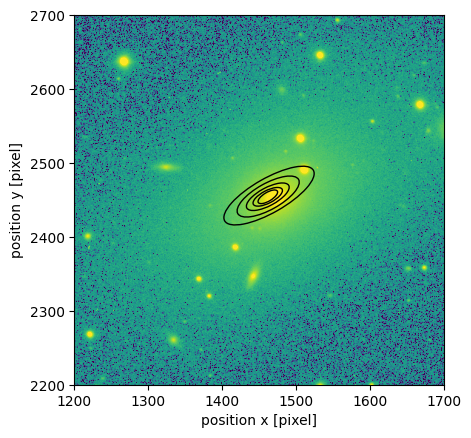

In [15]:
from matplotlib.patches import Ellipse

fig,ax = plt.subplots()
def scale(img):
    return np.arcsinh(img-2900)
cb = ax.imshow(scale(rband[2200:2700, 1200:1700]), extent=[1200,1700,2200,2700], origin='lower', vmin=0,vmax=9)
#fig.colorbar(cb)

ax.set_xlabel("position x [pixel]")
ax.set_ylabel("position y [pixel]")

print(len(iso_v_matched))
for i in iso_v_matched[35::4]:
    print(i.x0, i.y0, i.sma, i.pa)
    #axratio = 
    ellipses = Ellipse(xy=(i.x0, i.y0), width=2*i.sma, height=i.sma*(1.-i.eps), angle=np.rad2deg(i.pa), fill=False) #for i in iso_v_matched[::10]
    #print(iso_v_matched[3])
    ax.add_artist(ellipses)

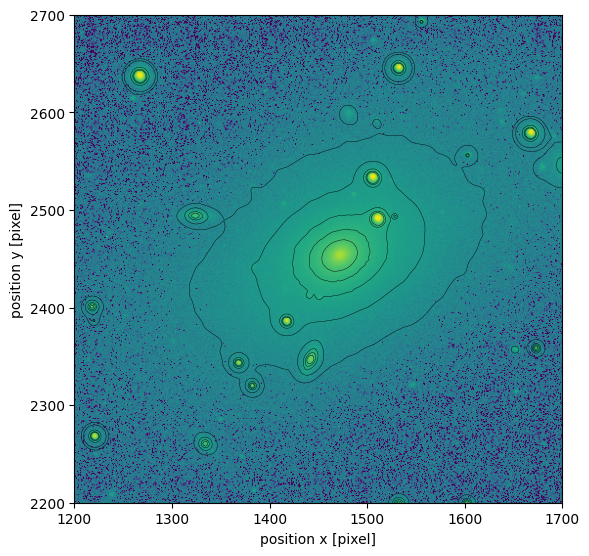

In [42]:
from matplotlib.patches import Ellipse
from skimage import measure
import scipy
import scipy.ndimage

cutout = rband[2200:2700, 1200:1700]
fig,ax = plt.subplots(tight_layout=True, figsize=(6,6))
def scale(img):
    return np.arcsinh(img-2900)
cb = ax.imshow(scale(cutout), extent=[1200,1700,2200,2700], origin='lower', vmin=0,vmax=12)
#fig.colorbar(cb)

ax.set_xlabel("position x [pixel]")
ax.set_ylabel("position y [pixel]")

levels = [(3050,5), (3200,5),(3500,2),(4000,1),(5000,1)]
for level,smooth in levels:
    
    smoothed = scipy.ndimage.gaussian_filter(cutout, smooth)
    contours = measure.find_contours(smoothed, level)
    for c in contours:
        ax.plot(c[:,1]+1200, c[:,0]+2200, c='black', lw=0.3)
        
fig.savefig("/work/contour_lines.png", dpi=200)